## 視覺化

### 先照之前的，讀取資料

In [1]:
import tqdm
import tarfile
import pandas
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import gzip
from urllib.request import urlopen
%matplotlib inline
matplotlib.style.use('seaborn-bright')
# progress bar
tqdm.tqdm.pandas()

# 檔案名稱格式
filename_format="M06A_{year:04d}{month:02d}{day:02d}.tar.gz".format
xz_filename_format="xz/M06A_{year:04d}{month:02d}{day:02d}.tar.xz".format
csv_format = "M06A/{year:04d}{month:02d}{day:02d}/{hour:02d}/TDCS_M06A_{year:04d}{month:02d}{day:02d}_{hour:02d}0000.csv".format

# 設定欄位名稱
M06A_fields = ['VehicleType',
               'DetectionTime_O','GantryID_O',
               'DetectionTime_D','GantryID_D ',
               'TripLength', 'TripEnd', 'TripInformation']
import datetime
# 用來解析時間格式
def strptime(x):
    return datetime.datetime(int(x[:4]), int(x[5:7]), int(x[8:10]), 
                             int(x[11:13]), int(x[14:16]), int(x[17:19]) )

def parse_tripinfo(tripinfo):
    split1 = tripinfo.split("; ")
    return [(strptime(t), t[20:]) for t in split1]

In [2]:
## 讀取檔案
node_data=pandas.read_json('node_data.json')
speedlimit = pandas.read_json('speedlimit.json')

## 依照速限來找更多的超速

In [4]:
# 這個改了一點， SpeedInfo 這個 named tuple 同時紀錄了區段的起始時間和兩端點
from collections import namedtuple
SpeedInfo = namedtuple("SpeedInfo", ["speed", "time","loc1", "loc2"])

def compute_speed(trip):
    rtn = []
    for (t1,n1), (t2,n2) in zip(trip[:-1], trip[1:]):
        if n1[:3] != n2[:3] or n1[-1]!=n2[-1]:
            continue
        if n1[3]=='R' or n2[3]=='R': 
            continue
        km1 = int(n1[3:-1])/10
        km2 = int(n2[3:-1])/10
        hr_delta = (t2-t1).total_seconds()/60/60
        speed = abs(km2-km1)/hr_delta
        rtn.append(SpeedInfo(speed, t1, n1, n2))
    return rtn 

In [5]:
# 打開剛才下載的檔案試試
data_config ={"year":2016, "month":12, "day":18}
tar = tarfile.open(filename_format(**data_config), 'r')

# 如果沒有下載，可以試試看 xz 檔案
#data_dconfig ={"year":2016, "month":11, "day":18}
#tar = tarfile.open(xz_filename_format(**data_config), 'r')

In [6]:
csvs = (tar.extractfile(csv_format(hour=hr, **data_config)) for hr in tqdm.trange(24))
data = pandas.concat([pandas.read_csv(csv, names=M06A_fields) for csv in csvs])
print("資料大小", data.shape)
# 檢查異常的資料
print("異常資料數:", data[data.TripEnd == 'N'].shape[0])
# 去除異常資料
data = data[data.TripEnd == 'Y']
# 只保留 TripInformation 和 VehicleType
data = data[['VehicleType', "TripInformation"]]

data['Trip'] = data.TripInformation.progress_apply(parse_tripinfo)
data['Speed'] = data.Trip.progress_apply(compute_speed)

100%|██████████| 24/24 [00:38<00:00,  1.55s/it]


資料大小 (3350606, 8)
異常資料數: 0


100%|██████████| 3350606/3350606 [00:51<00:00, 64993.33it/s] 


In [7]:
speedlimit_lookup = node_data.速限.to_dict()

def is_speeding(info):
    speedlimit = max(speedlimit_lookup[info.loc1], speedlimit_lookup[info.loc2])
    return info.speed > speedlimit + 10

# 存下所有超速的判斷
data['超速紀錄'] = data.Speed.progress_apply(lambda l:[is_speeding(x) for x in l])


100%|██████████| 3350606/3350606 [00:38<00:00, 86406.62it/s] 


In [8]:
data.head(10)

,VehicleType,TripInformation,Trip,Speed,超速紀錄
0,31,2016-12-18 00:31:53+03F2079S; 2016-12-18 00:32...,"[(2016-12-18 00:31:53, 03F2079S), (2016-12-18 ...","[(123.93442622950788, 2016-12-18 00:31:53, 03F...",[True]
1,31,2016-12-18 00:37:31+03F2194S; 2016-12-18 00:40...,"[(2016-12-18 00:37:31, 03F2194S), (2016-12-18 ...","[(117.65853658536565, 2016-12-18 00:37:31, 03F...",[False]
2,31,2016-12-18 00:47:56+03F2415S,"[(2016-12-18 00:47:56, 03F2415S)]",[],[]
3,31,2016-12-18 00:22:29+01H0447N; 2016-12-18 00:29...,"[(2016-12-18 00:22:29, 01H0447N), (2016-12-18 ...","[(99.75903614457827, 2016-12-18 00:29:45, 01F0...","[False, False, False]"
4,31,2016-12-18 00:35:55+01F0633S; 2016-12-18 00:37...,"[(2016-12-18 00:35:55, 01F0633S), (2016-12-18 ...","[(106.28571428571458, 2016-12-18 00:35:55, 01F...","[False, True, False, False, False, False, Fals..."
5,32,2016-12-18 00:21:00+05F0438N; 2016-12-18 00:22...,"[(2016-12-18 00:21:00, 05F0438N), (2016-12-18 ...",[],[]
6,32,2016-12-18 00:10:59+01F0005S; 2016-12-18 00:11...,"[(2016-12-18 00:10:59, 01F0005S), (2016-12-18 ...","[(86.39999999999999, 2016-12-18 00:10:59, 01F0...","[False, False, False, False, False, False, Fal..."
7,31,2016-12-18 00:35:09+01F0017N,"[(2016-12-18 00:35:09, 01F0017N)]",[],[]
8,31,2016-12-18 00:26:36+01F1621S; 2016-12-18 00:28...,"[(2016-12-18 00:26:36, 01F1621S), (2016-12-18 ...","[(115.52238805970178, 2016-12-18 00:26:36, 01F...","[True, True]"
9,31,2016-12-18 00:18:25+01F3525S; 2016-12-18 00:20...,"[(2016-12-18 00:18:25, 01F3525S), (2016-12-18 ...","[(99.69230769230833, 2016-12-18 00:18:25, 01F3...","[False, True, False]"


## 用 dict 直接統計
### 以 S01F 為例

In [9]:
node_data

,Unnamed: 6,Unnamed: 8,交流道(起),交流道(迄),小車牌價,收費區 設定里程,方向,經度(東經),編號,緯度(北緯),速限
01F0005N,N,E,基隆(長庚醫院),基隆端(基隆港),1.3,1.1,N,121.731636,01F0005N,25.118311,100
01F0005S,N,E,基隆端(基隆港),基隆(長庚醫院),1.3,1.1,S,121.731764,01F0005S,25.118786,100
01F0017N,N,E,八堵,基隆(長庚醫院),1.4,1.2,N,121.725906,01F0017N,25.109567,100
01F0017S,N,E,基隆(長庚醫院),八堵,1.4,1.2,S,121.725906,01F0017S,25.109567,100
01F0029N,N,E,大華系統(連接台62),八堵,3.3,2.8,N,121.717369,01F0029N,25.103111,100
01F0029S,N,E,八堵,大華系統(連接台62),3.3,2.8,S,121.717369,01F0029S,25.103111,100
01F0061N,N,E,五堵,大華系統(連接台62),2.1,1.8,N,121.693483,01F0061N,25.088394,100
01F0061S,N,E,大華系統(連接台62),五堵,2.1,1.8,S,121.693483,01F0061S,25.088394,100
01F0099N,N,E,汐止&汐止系統(連接國3),五堵,4.4,3.7,N,121.659422,01F0099N,25.076044,100
01F0099S,N,E,五堵,汐止&汐止系統(連接國3),4.4,3.7,S,121.659478,01F0099S,25.076264,100


In [10]:
S01F_list = list(sorted(x for x in node_data.編號 if x.startswith('01F') and x.endswith('S')))

In [11]:
S01F = {s:i for i,s in enumerate(S01F_list)}

In [12]:
len(S01F)

73

In [13]:
speedlimit_lookup = node_data.速限.to_dict()
start_time = datetime.datetime(data_config['year'],data_config['month'],data_config['day'])
end_time = datetime.datetime(data_config['year'],data_config['month'],data_config['day']+1)
total_statistics=np.zeros((24*4, len(S01F)), dtype=int)
speeding_statistics=np.zeros((24*4, len(S01F)), dtype=int)

def count_speeding(info):
    if not info.loc1.startswith('01F'):
        return
    if not info.loc1.endswith('S'):
        return
    if info.loc1 > info.loc2:
        return

    idx = int((info.time-start_time).seconds/(15*60))
    idx2 = S01F[info.loc1]
    total_statistics[idx][idx2] += 1
    speedlimit = max(speedlimit_lookup[info.loc1], speedlimit_lookup[info.loc2])
    if info.speed > speedlimit + 10:
        speeding_statistics[idx][idx2] += 1

# 存下所有超速的判斷
data.Speed.apply(lambda l:[count_speeding(x) for x in l]);


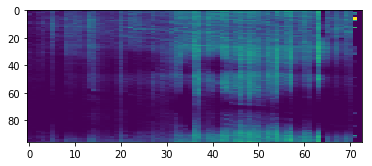

In [14]:
plt.imshow(speeding_statistics/(total_statistics+0.001), aspect=0.3);

In [15]:
# 從 00Download.ipynb 來的
from urllib.request import urlopen
def download_req(req, filename):
    total = int(req.getheader("Content-Length"))
    tqdm_conf = dict(total=total, desc=filename, unit='B', unit_scale=True)
    with tqdm.tqdm(**tqdm_conf) as pbar:
        with open(filename,'wb') as f:
            for data in iter(lambda: req.read(8192), b""):  
                pbar.update(f.write(data))

# 字體下載
font_url = "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip"
# 改變這行才能真正下載
if False:
    with urlopen(font_url) as req:
        download_req(req, "NotoSansCJKtc-hinted.zip")
    # Extract Font files
    import zipfile
    with zipfile.ZipFile("NotoSansCJKtc-hinted.zip") as zf:
        for f in zf.namelist():
            if f.endswith('.otf'):
                print("extract", f)
                zf.extract(f)

In [16]:
# if you can find the Chinese font in your system
#plt.rcParams['font.family'] = 'AR PL Mingti2L Big5' # works on Ubuntu

In [17]:
fp = matplotlib.font_manager.FontProperties(fname = 'NotoSansCJKtc-Regular.otf')
matplotlib.font_manager.fontManager.ttffiles.append(fp.get_file())
font_entry = matplotlib.font_manager.FontEntry(fp.get_file(), fp.get_name(),
                                               fp.get_style(), fp.get_variant(),
                                              fp.get_weight(), fp.get_stretch(), fp.get_size())

matplotlib.font_manager.fontManager.ttflist.append(font_entry)
plt.rcParams['font.family'] = fp.get_name()

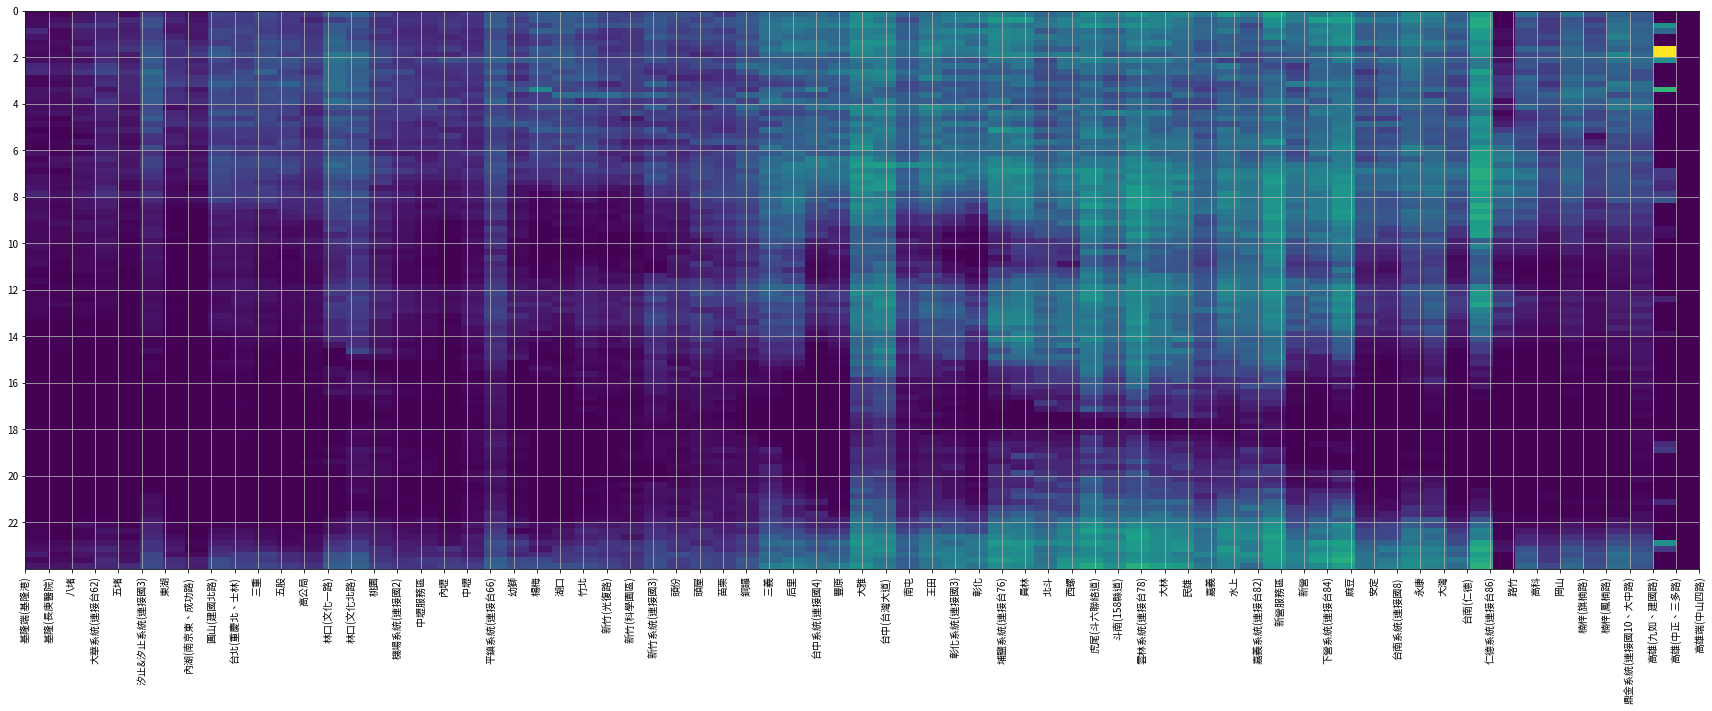

In [18]:
plt.figure(figsize=(30,40));
plt.imshow((speeding_statistics/(total_statistics+0.001)), aspect=1, 
           interpolation='none',
           extent=[0,72,24,0]
          )
ax = plt.gca()
ax.set_yticks(range(0,24,2));
plt.xticks(range(73), [node_data['交流道(起)'][S01F_list[i]] for i in range(73)], 
          rotation='vertical');
plt.grid(True)

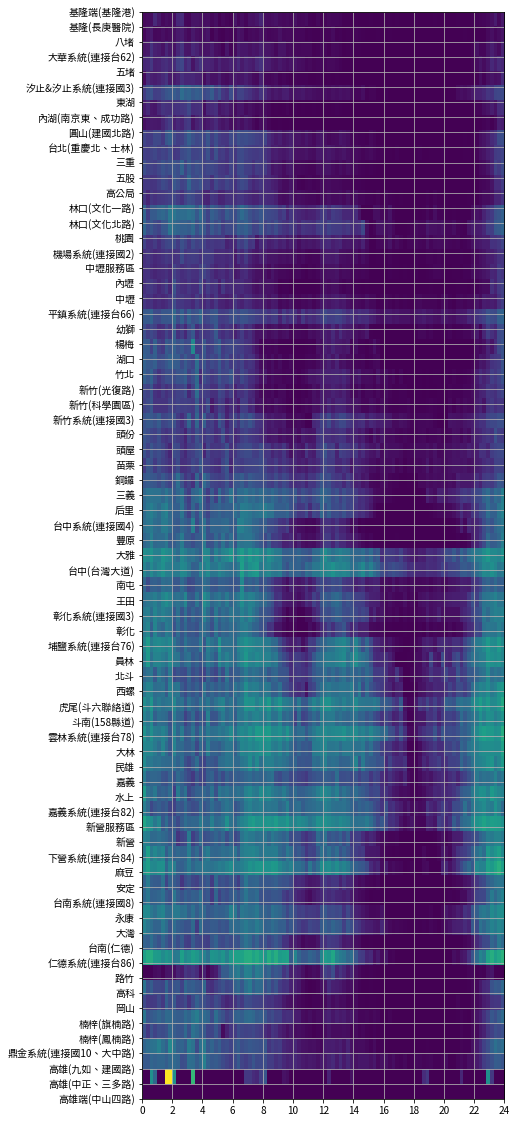

In [19]:
plt.figure(figsize=(15,20));
plt.imshow((speeding_statistics/(total_statistics+0.001)).T, aspect=1, 
           interpolation='none',
           extent=[0,24,72,0])
ax = plt.gca()
ax.set_xticks(range(0,26,2));
plt.yticks(range(73), [node_data['交流道(起)'][S01F_list[i]] for i in range(73)], 
          #fontproperties=fp, #or fontname='AR PL Mingti2L Big5' #'Droid Sans Fallback');
          );
plt.grid(True)

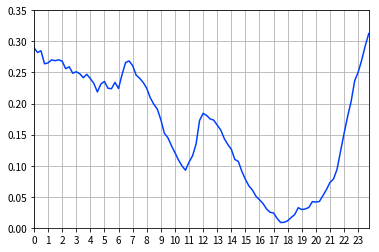

In [20]:
plt.plot(speeding_statistics.sum(axis=1)/(total_statistics.sum(axis=1)+0.00001) );
plt.xticks(range(0,24*4,4), range(24));
plt.grid(True);
plt.xlim(0,24*4-1);
plt.ylim(0, 0.35);

In [57]:
matplotlib.style.use('seaborn-deep')

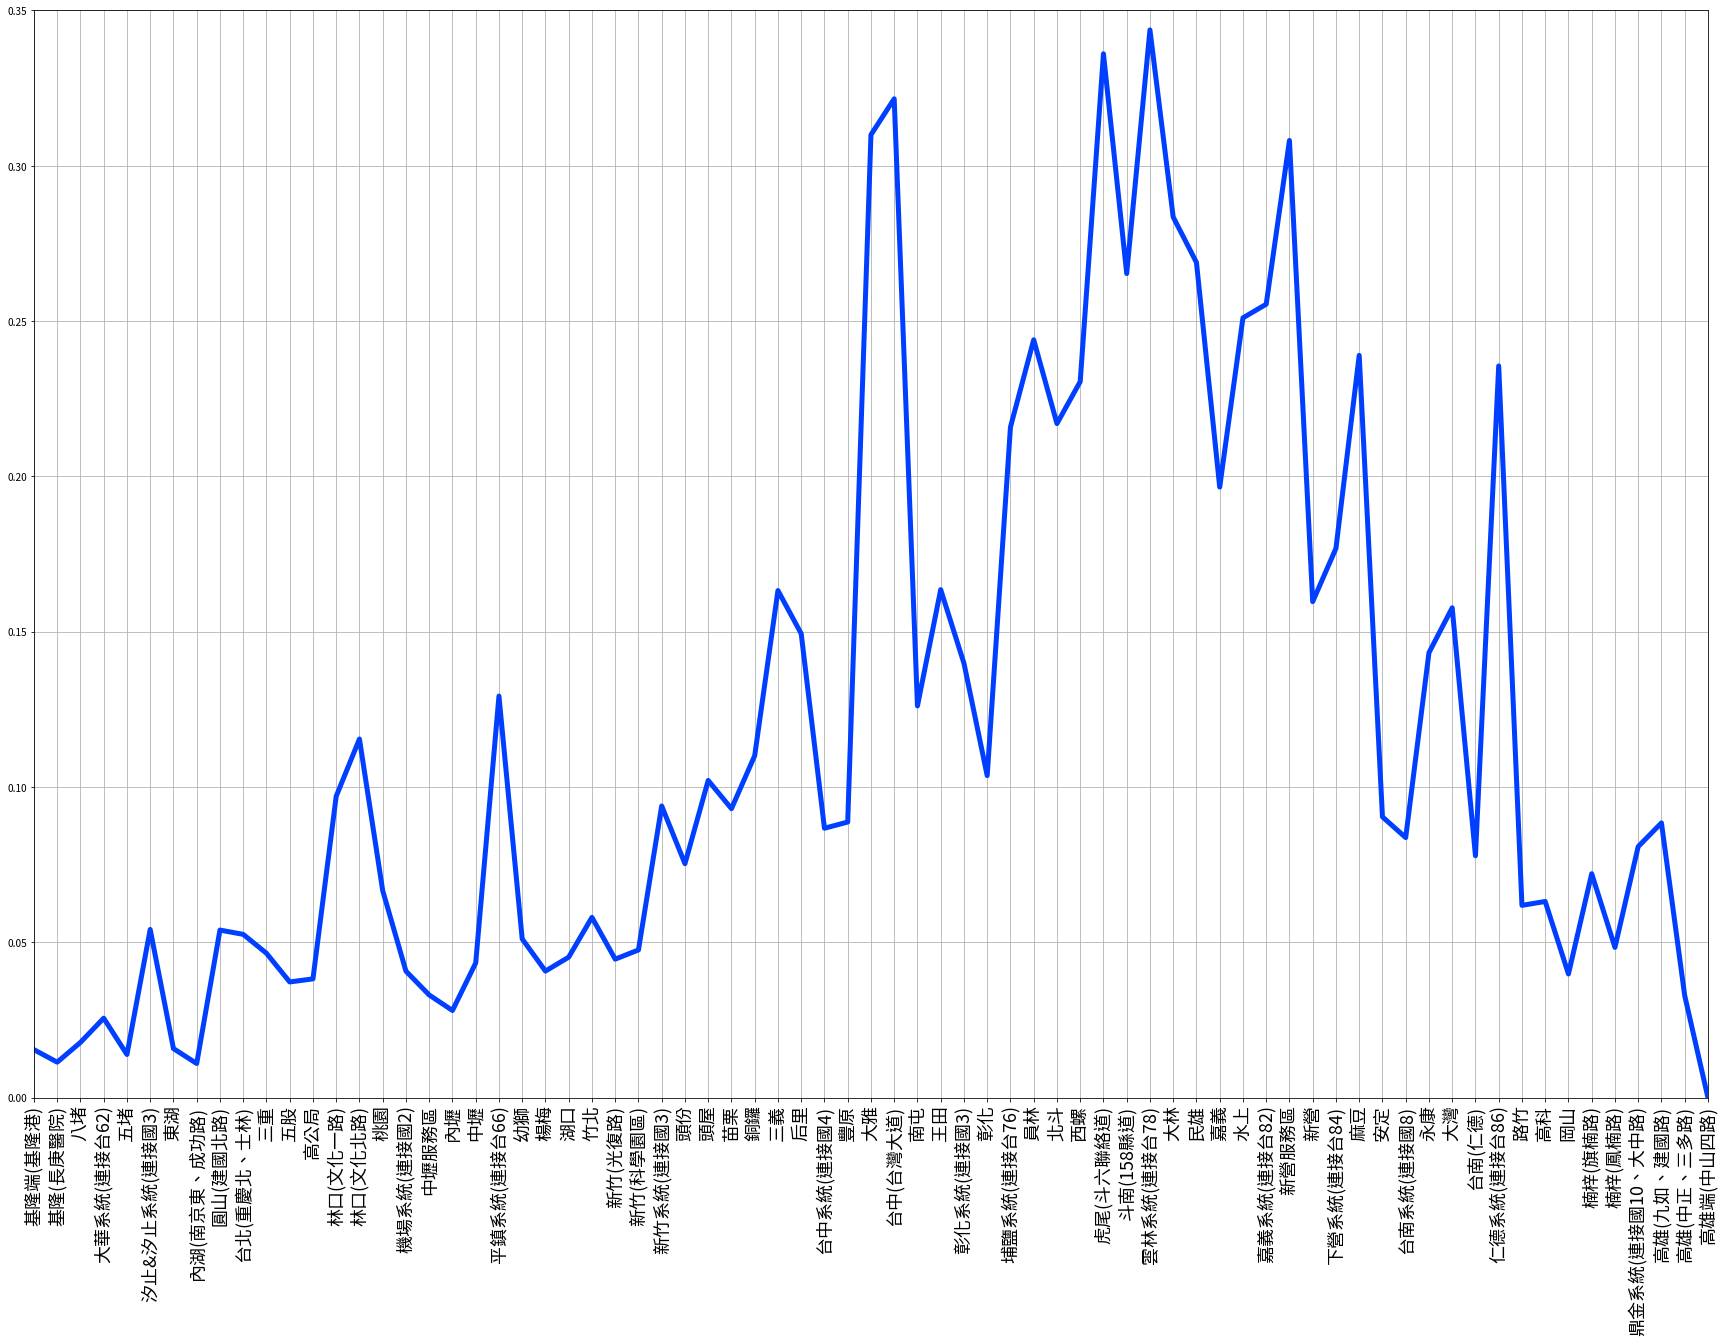

In [21]:
plt.figure(figsize=(30,20))
plt.plot(speeding_statistics.sum(axis=0)/(total_statistics.sum(axis=0)+0.00001),
        linewidth=5);
plt.xticks(range(73), [node_data['交流道(起)'][S01F_list[i]] for i in range(73)], 
          rotation=90, fontsize=18);
plt.grid(True);
plt.xlim(0,72);
plt.ylim(0, 0.35);

## 用 pandas 來算

In [26]:
# 將 data.Speed 展開成 DataFrame
from itertools import chain
speed_data = pandas.DataFrame.from_records(chain(*data.Speed), columns=SpeedInfo._fields )
speed_data.head(10)

,speed,time,loc1,loc2
0,123.934426,2016-12-18 00:31:53,03F2079S,03F2100S
1,117.658537,2016-12-18 00:37:31,03F2194S,03F2261S
2,99.759036,2016-12-18 00:29:45,01F0339N,01F0293N
3,102.461538,2016-12-18 00:32:31,01F0293N,01F0256N
4,69.579832,2016-12-18 00:34:41,01F0256N,01F0233N
5,106.285714,2016-12-18 00:35:55,01F0633S,01F0664S
6,120.000000,2016-12-18 00:37:40,01F0664S,01F0681S
7,108.471616,2016-12-18 00:38:31,01F0681S,01F0750S
8,106.363636,2016-12-18 00:42:20,01F0750S,01F0880S
9,108.000000,2016-12-18 00:49:40,01F0880S,01F0928S


In [27]:
# 計算是否超速（完全跟前面一樣，雖然現在 info 是 pandas.Series）
def is_speeding(info):
    speedlimit = max(speedlimit_lookup[info.loc1], speedlimit_lookup[info.loc2])
    return info.speed > speedlimit + 10

# 存下所有超速的判斷
# 這樣會很慢，而且撞到 tdqm 的雷
# speed_data['超速'] = speed_data.progress_apply(is_speeding, axis=1)

In [28]:
# 用 pandas 的方法做
speed_loc1 = speed_data.loc1.apply(speedlimit_lookup.get)
speed_loc2 = speed_data.loc1.apply(speedlimit_lookup.get)
speed_max = pandas.DataFrame({'1':speed_loc1, '2:':speed_loc2}).max(axis=1)
speed_data['超速'] = speed_data.speed > speed_max +10

In [29]:
ts = speed_data.time.apply(lambda t:t.hour*4+t.minute//15)

In [30]:
groups = speed_data[['speed','超速']].groupby([speed_data.loc1, ts])

In [31]:
statistics = groups.mean()
statistics

speed        超速
loc1     time                      
01F0005S 0      91.339525  0.025000
         1      90.096541  0.032520
         2      90.007746  0.036364
         3      90.976999  0.117647
         4      91.378606  0.062500
         5      88.721224  0.027273
         6      93.298005  0.039216
         7      91.298857  0.030612
         8      92.528099  0.037383
         9      94.265506  0.115702
         10     92.845893  0.125000
         11     89.402583  0.021505
         12     90.309230  0.019048
         13     91.015407  0.053571
         14     90.081298  0.050847
         15     92.335860  0.045455
         16     88.441058  0.037313
         17     87.653106  0.040323
         18     89.604950  0.023121
         19     88.952555  0.038961
         20     87.500940  0.006536
         21     89.192904  0.024590
         22     87.932310  0.013514
         23     87.550966  0.006993
         24     86.789573  0.055556
         25     91.317817  0.019481
         26     91.604643  0.038961
         27     87.958280  0.017647
         28     90.873712  0.049383
         29     91.812922  0.044944
...                   ...       ...
05F0528N 66     98.462766  0.386364
         67     97.553508  0.393258
         68     98.314794  0.547368
         69     95.673290  0.278481
         70     93.417321  0.244186
         71     97.242882  0.333333
         72     96.661253  0.350649
         73     95.740476  0.313433
         74     90.615817  0.224138
         75     91.017493  0.157143
         76     98.822382  0.376471
         77     93.114577  0.281250
         78     91.417308  0.207792
         79     95.015914  0.336735
         80     97.637380  0.377358
         81     95.678751  0.373737
         82     93.206444  0.216867
         83     95.253912  0.271605
         84     94.819362  0.272727
         85     94.573424  0.369565
         86     94.537388  0.226415
         87     91.459940  0.159420
         88     94.900567  0.244444
         89    102.001361  0.483871
         90     96.809996  0.288136
         91     95.462721  0.225000
         92     90.308632  0.170732
         93     97.650355  0.390244
         94     95.305009  0.352941
         95     97.749798  0.285714

[30514 rows x 2 columns]

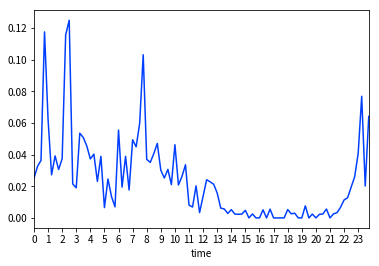

In [32]:
statistics.loc['01F0005S']['超速'].plot()
plt.xticks(range(0,24*4,4), range(24));

## Q
利用 `statistics` 來繪圖

### 利用  bokeh

In [37]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [30]:
from bokeh.charts import Bar, show
from bokeh.models import FixedTicker
from bokeh.models.formatters import TickFormatter, String, List

class FixedTickFormatter(TickFormatter):
    """
    Class used to allow custom axis tick labels on a bokeh chart
    Extends bokeh.model.formatters.TickFormatte
    """

    JS_CODE =  """
        import {Model} from "model"
        import * as p from "core/properties"
        export class FixedTickFormatter extends Model
          type: 'FixedTickFormatter'
          
          doFormat: (ticks) ->
            labels = @labels
            return (labels[tick] ? "" for tick in ticks)
          @define {
            labels: [ p.Any ]
          }
    """

    labels = List(String, help="""
    A mapping of integer ticks values to their labels.
    """)

    __implementation__ = JS_CODE

In [44]:
x = range(73)
y = speeding_statistics.sum(axis=0)/(total_statistics.sum(axis=0)+0.00001)
p = figure(title="超速比例", plot_height=500, 
           plot_width=800, x_range=(0,72), y_range=(0,y.max()*1.05))
r = p.line(x, y, color="#2222aa", line_width=3)
#node_data['交流道(起)'][S01F_list[i]
labels = [node_data['交流道(起)'][S01F_list[i]] for i in range(73)]
p.xaxis[0].formatter = FixedTickFormatter(labels=labels)
p.xaxis[0].ticker = FixedTicker(ticks=list(range(73)))
p.xaxis.major_label_orientation = 3.14/2

In [45]:
show(p, notebook_handle=True);

In [57]:
from bokeh.io import show
from bokeh.charts import Bar
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
y0 = statistics.loc['01F0005S']['超速']
y1 = statistics.loc['01F0005S']['speed']
x = np.arange(0,24,0.25)

# create a column data source for the plots to share
source = ColumnDataSource(data=dict(x=x, y0=y0, y1=y1))

TOOLS = "box_select,lasso_select,help"

# create a new plot and add a renderer
left = figure(tools=TOOLS, width=300, height=300, title=None)
left.square('x', 'y0', source=source)
left.line('x', 'y0', source=source)


# create another new plot and add a renderer
right = figure(tools=TOOLS, width=300, height=300, title=None)
right.square('x', 'y1', source=source)
right.line('x', 'y1', source=source)


p = gridplot([[left, right]])

show(p)